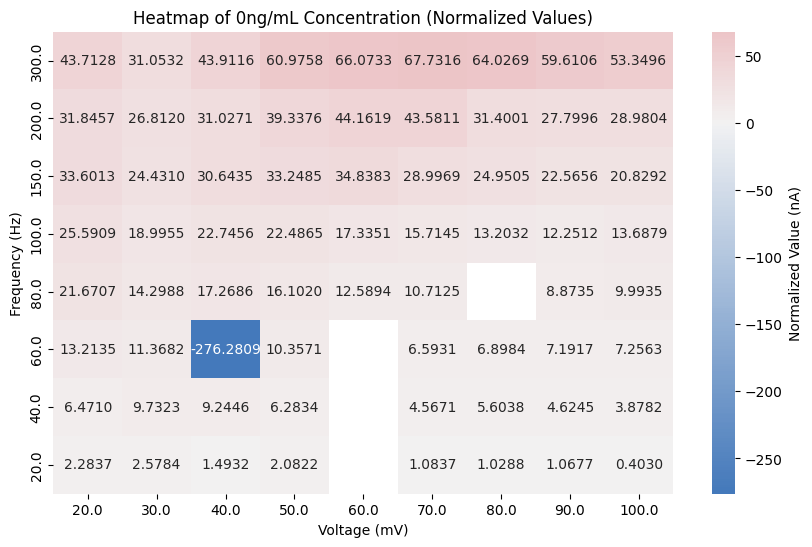

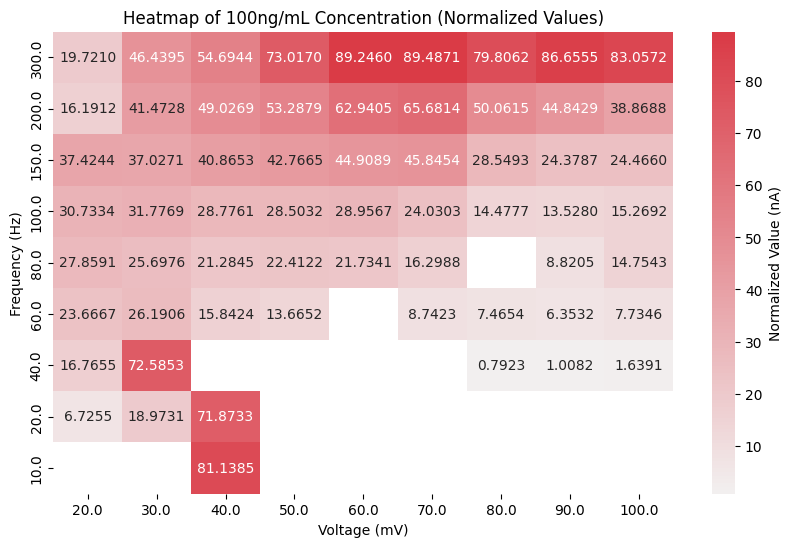

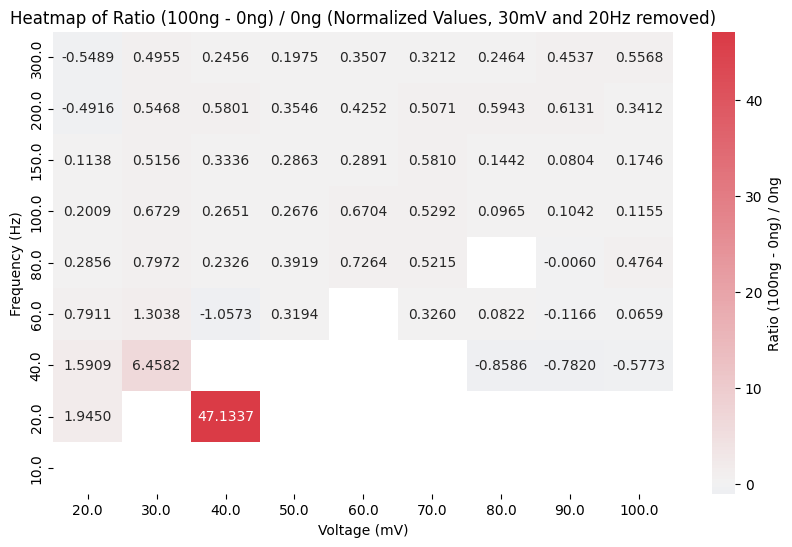

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the Excel file
file_path = r"C:\Users\kulma\OneDrive\Documents\School\MASc Year 1\Surface Profilometry Analyzer\Surface-Profilometry-Analyzer\Peak picking algorithm\Normalized CSV Files\Final Values Sorted.xlsx"
xls = pd.ExcelFile(file_path)

# Load the data from the first sheet
df = pd.read_excel(xls, sheet_name='Sheet1')

# Remove rows where Instance ends in 'uA' without any number
df_filtered = df[~df['Instance'].str.match(r'uA$')].copy()

# Remove rows where Instance is 'µA1', 'µA5', or 'µA7'
df_filtered = df_filtered[~df_filtered['Instance'].isin(['µA1', 'µA5', 'µA7'])]

# Group values from uA2 to uA4 as 0ng/mL and uA6 to uA8 as 100ng/mL
df_filtered.loc[:, 'Concentration'] = df_filtered['Instance'].apply(
    lambda x: '0ng/mL' if x in ['µA2', 'µA3', 'µA4'] else '100ng/mL'
)

# Divide the 'Lowest Trough Value' by -1
df_filtered['Lowest Trough Value'] = df_filtered['Lowest Trough Value'] / -1

# Load the surface area values
surface_areas = {
    'uA2': 1.323834197,
    'uA3': 1.481865285,
    'uA4': 1.945595855,
    'uA6': 1.733160622,
    'uA8': 1.906735751
}

# Function to divide values by surface area based on the 'Instance' column
def divide_by_surface_area(instance, value):
    key = instance.replace('µA', 'uA')
    return value / surface_areas.get(key, 1)

# Apply the function to the dataframe
df_filtered['Normalized Value'] = df_filtered.apply(lambda row: divide_by_surface_area(row['Instance'], row['Lowest Trough Value']), axis=1)

# Calculate the average of each concentration with normalized values
df_grouped_normalized = df_filtered.groupby(['Frequency (Hz)', 'Voltage (mV)', 'Concentration'])['Normalized Value'].mean().reset_index()

# Convert Frequency and Voltage columns to numeric values for proper sorting
df_grouped_normalized['Frequency (Hz)'] = df_grouped_normalized['Frequency (Hz)'].str.replace('Hz', '').astype(float)
df_grouped_normalized['Voltage (mV)'] = df_grouped_normalized['Voltage (mV)'].str.replace('mV', '').astype(float)

# Separate the data for 0ng/mL and 100ng/mL again after conversion
df_0ng_normalized = df_grouped_normalized[df_grouped_normalized['Concentration'] == '0ng/mL']
df_100ng_normalized = df_grouped_normalized[df_grouped_normalized['Concentration'] == '100ng/mL']

# Create pivot tables for heatmap plotting, ensuring the sorting
pivot_0ng_normalized = df_0ng_normalized.pivot(index='Frequency (Hz)', columns='Voltage (mV)', values='Normalized Value').sort_index().sort_index(axis=1)
pivot_100ng_normalized = df_100ng_normalized.pivot(index='Frequency (Hz)', columns='Voltage (mV)', values='Normalized Value').sort_index().sort_index(axis=1)

# Convert µA values to nA for both 0ng and 100ng data
pivot_0ng_normalized_nA = pivot_0ng_normalized * 1000
pivot_100ng_normalized_nA = pivot_100ng_normalized * 1000

# Recalculate the ratio (100ng - 0ng) / 0ng with the converted values
ratio_pivot_normalized_nA = (pivot_100ng_normalized_nA - pivot_0ng_normalized_nA) / pivot_0ng_normalized_nA

# Remove the value for 30mV and 20Hz
ratio_pivot_normalized_nA.loc[20, 30] = None

# Reverse the frequency order for plotting from small at bottom to large at top
pivot_0ng_normalized_nA = pivot_0ng_normalized_nA.iloc[::-1]
pivot_100ng_normalized_nA = pivot_100ng_normalized_nA.iloc[::-1]
ratio_pivot_normalized_nA = ratio_pivot_normalized_nA.iloc[::-1]

# Plot the heatmaps with blue and red colors, using gradients for positive and negative values
darker_blue_red_cmap = sns.diverging_palette(250, 10, n=9, as_cmap=True)

# Plot the heatmap for 0ng/mL with normalized values
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_0ng_normalized_nA, annot=True, fmt=".4f", cmap=darker_blue_red_cmap, cbar_kws={'label': 'Normalized Value (nA)'}, center=0)
plt.title('Heatmap of 0ng/mL Concentration (Normalized Values)')
plt.show()

# Plot the heatmap for 100ng/mL with normalized values
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_100ng_normalized_nA, annot=True, fmt=".4f", cmap=darker_blue_red_cmap, cbar_kws={'label': 'Normalized Value (nA)'}, center=0)
plt.title('Heatmap of 100ng/mL Concentration (Normalized Values)')
plt.show()

# Plot the heatmap for the ratio with normalized values
plt.figure(figsize=(10, 6))
sns.heatmap(ratio_pivot_normalized_nA, annot=True, fmt=".4f", cmap=darker_blue_red_cmap, cbar_kws={'label': 'Ratio (100ng - 0ng) / 0ng'}, center=0)
plt.title('Heatmap of Ratio (100ng - 0ng) / 0ng (Normalized Values, 30mV and 20Hz removed)')
plt.show()
